In [1]:
!pip install torch torchvision torchaudio
!pip install scikit-learn matplotlib seaborn tqdm
#to install necessary software packages and software

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from torchvision.models import resnet18, ResNet18_Weights

from sklearn.metrics import classification_report, confusion_matrix
#to use important python librareies

In [3]:
#resize all the images to the sasme size for consistent evaluation and loads training and test images separately
DATA_DIR = "/content/drive/MyDrive/ISIC/processed"

train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_ds = ImageFolder(DATA_DIR + "/train", transform=train_tf)
test_ds  = ImageFolder(DATA_DIR + "/test", transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=8, shuffle=False)

print("Train samples:", len(train_ds))
print("Test samples:", len(test_ds))


Train samples: 38
Test samples: 10


In [4]:
#creates a 2 layer CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            #1st layer has 3 input and 16 filters
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            #2nd layer has 16 input from layer 1 to 32 filters
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(32*56*56, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# for faster training with gpu
cnn_model = SimpleCNN().cuda()


In [5]:
#calls resnet model which consists of 18 layers for image classification and recognition
resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, 2)
resnet = resnet.cuda()


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 212MB/s]


In [6]:
def train_model(model, epochs=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        model.train()
        for imgs, labels in train_loader:
            imgs, labels = imgs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1} completed")

print("Training CNN")
train_model(cnn_model)

print("Training ResNet")
train_model(resnet)


Training CNN
Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Training ResNet
Epoch 1 completed
Epoch 2 completed
Epoch 3 completed


In [7]:
def evaluate(model):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.cuda()
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))


In [8]:
print("CNN Results")
evaluate(cnn_model)

print("ResNet Results")
evaluate(resnet)


CNN Results


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.70      1.00      0.82         7

    accuracy                           0.70        10
   macro avg       0.35      0.50      0.41        10
weighted avg       0.49      0.70      0.58        10

[[0 3]
 [0 7]]
ResNet Results
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.70      1.00      0.82         7

    accuracy                           0.70        10
   macro avg       0.35      0.50      0.41        10
weighted avg       0.49      0.70      0.58        10

[[0 3]
 [0 7]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


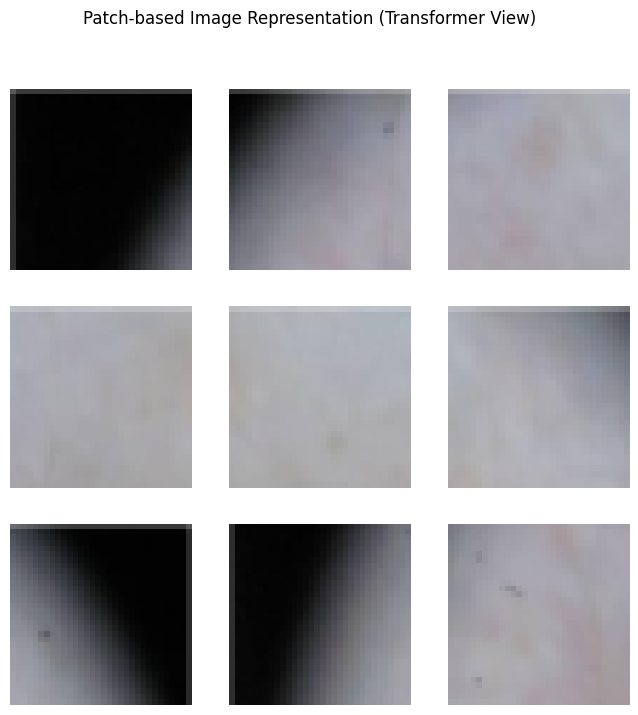

In [9]:
import matplotlib.pyplot as plt

imgs, _ = next(iter(train_loader))
img = imgs[0]

patch_size = 32
patches = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
patches = patches.permute(1,2,0,3,4).reshape(-1,3,patch_size,patch_size)

plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(patches[i].permute(1,2,0))
    plt.axis('off')
plt.suptitle("Patch-based Image Representation (Transformer View)")
plt.show()
